# ABIDE PREPROC PHENO
Ok, this is all messy. Here is what I need to establish:

1) abide and abide_preproc pheno are identical regarding Age, Sex, Diagnosis and FIQ of all matched subjects

2) abide_preproc and niak_local have the same or at least correlated motion estimates after subject matching

3) assess the overlap between the QC results of abide_preproc and niak_local

Then make this happen:

1) merge abide_preproc with niak_local QC

2) merge that with Budha's ADOS severity scores

3) run the propensity score matching on that stuff

In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats as st
from matplotlib import pyplot as plt

In [2]:
%matplotlib inline

In [3]:
# Set up the paths
path_abide_preproc = '/data1/abide/Pheno/new/abide_preprocessed_full_pheno.csv'
path_abide_raw = '/data1/abide/Pheno/new/abide_data_full_pheno.csv'
path_ados = '/data1/abide/Pheno/old/ados_pheno.csv'
tmp_niak_scrubbing = '/data1/abide/Pheno/new/{}_qc_scrubbing_group.csv'
tmp_niak_motion = '/data1/abide/Pheno/new/{}_qc_motion_group.csv'
tmp_niak_qc = '/data1/abide/Pheno/new/{}_qc_report.csv'
qc_maybe_out = '/data1/abide/Pheno/psm/abide_qc_maybe.csv'
qc_pass_out = '/data1/abide/Pheno/psm/abide_qc_pass.csv'

## Load abide_raw and abide_preproc and compare their values
particularly:
- age
- sex
- diagnosis
- FIQ

In [4]:
# Load both pheno frames
abide_pre = pd.read_csv(path_abide_preproc)
abide_raw = pd.read_csv(path_abide_raw)

In [5]:
# Match them by the subject id
abide_combined = pd.merge(abide_pre, abide_raw, on='SUB_ID', how='outer')

In [6]:
# Check the columns and see if they are the same
abide_combined[['AGE_AT_SCAN_x', 'AGE_AT_SCAN_y', 'DX_GROUP_x', 'DX_GROUP_y', 'SEX_x', 'SEX_y', 'FIQ_x', 'FIQ_y']].head()

,AGE_AT_SCAN_x,AGE_AT_SCAN_y,DX_GROUP_x,DX_GROUP_y,SEX_x,SEX_y,FIQ_x,FIQ_y
0,16.77,16.77,1,1,1,1,103.0,103.0
1,24.45,24.45,1,1,1,1,124.0,124.0
2,19.09,19.09,1,1,1,1,113.0,113.0
3,13.73,13.73,1,1,2,2,119.0,119.0
4,13.37,13.37,1,1,1,1,109.0,109.0


Alright, looks pretty cool. Let's do it for real

In [7]:
test_age = all(abide_combined['AGE_AT_SCAN_x'].values == abide_combined['AGE_AT_SCAN_y'])
test_dx = all(abide_combined['DX_GROUP_x'].values == abide_combined['DX_GROUP_y'])
test_sex = all(abide_combined['SEX_x'].values == abide_combined['SEX_y'])
test_fiq = all(abide_combined['FIQ_x'].values == abide_combined['FIQ_y'])
print('age ({}), dx ({}), sex({}), fiq({})'.format(test_age, test_dx, test_sex, test_fiq))

age (True), dx (True), sex(True), fiq(False)


Aha, aha, what about the FIQ range? Let's check that

In [8]:
test_fiq_bool = abide_combined['FIQ_x'].values == abide_combined['FIQ_y']
a = [x[0] for x in np.argwhere(~test_fiq_bool)]
abide_combined.loc[a][['FIQ_x', 'FIQ_y']].head()

,FIQ_x,FIQ_y
553,NaN,NaN
554,NaN,NaN
555,NaN,NaN
556,NaN,NaN
557,NaN,NaN


Ah ok, all good then. NaN ~= NaN in python. Gotta remember that kids!

## ABIDE_preproc and niak_local motion comparison
First we have to make a combined local niak qc file

In [9]:
# Some sites are special wallflowers and need to be titlecase. Yay.
sites = ['Pitt', 'Olin', 'OHSU', 'SDSU', 'Trinity', 'UM_1', 'UM_2', 'USM', 'Yale', 'CMU_a', 'CMU_b',
        'Leuven_1', 'Leuven_2', 'KKI', 'NYU', 'Stanford', 'UCLA_1', 'UCLA_2',
         'MaxMun_a', 'MaxMun_b', 'MaxMun_c', 'MaxMun_d', 'Caltech', 'SBL']

In [10]:
# And then iterate over them to load the niak_qc_data
for s_id, site in enumerate(sites):
    #print(tmp_niak_qc.format(site.title()))
    tmp_qc = pd.read_csv(tmp_niak_qc.format(site))
    tmp_motion = pd.read_csv(tmp_niak_motion.format(site))
    tmp_scrub = pd.read_csv(tmp_niak_scrubbing.format(site))
    
    if s_id == 0:
        pheno_qc = tmp_qc
        pheno_motion = tmp_motion
        pheno_scrub = tmp_scrub
    else:
        pheno_qc = pd.concat([pheno_qc, tmp_qc])
        pheno_motion = pd.concat([pheno_motion, tmp_motion])
        pheno_scrub = pd.concat([pheno_scrub, tmp_scrub])

In [11]:
# Rename the subject column because its like a free for all
pheno_motion.rename(columns={' ': 'SUB_ID'}, inplace=True)
pheno_qc.rename(columns={'id_subject ': 'SUB_ID'}, inplace=True)
pheno_scrub.rename(columns={' ': 'SUB_ID_multi'}, inplace=True)
# Get rid of the weird leading characters of the sub ID
pheno_motion['SUB_ID'] = pheno_motion['SUB_ID'].str.replace(r'^X00', '').str.strip(' ')
pheno_qc['SUB_ID'] = pheno_qc['SUB_ID'].str.replace(r'^X00', '').str.strip(' ')
pheno_scrub['SUB_ID'] = pheno_scrub['SUB_ID_multi'].str.extract('((?<=X00)\d+)', expand=True)
# Get the session and run ID so we can later pick the best run for the duplicates
pheno_scrub['session'] = pheno_scrub['SUB_ID_multi'].str.extract('((?<=_session_)\d)', expand=True)
pheno_scrub['run'] = pheno_scrub['SUB_ID_multi'].str.extract('((?<=_run)\d)', expand=True)
# Now get rid of the sub_id_multi column, we don't need it anymore
pheno_scrub.drop('SUB_ID_multi', axis=1, inplace=True)
# Reset the index on the scrub phenotype data
pheno_scrub.set_index(np.arange(pheno_scrub.shape[0]), inplace=True)

In [12]:
# There are some subjects with multiple sessions, we want the ones with the best FD
dupl_subs = pheno_scrub[pheno_scrub.duplicated('SUB_ID')]['SUB_ID'].unique()
for sub in dupl_subs:
    # Find the vector of FD and names
    ids = pheno_scrub[pheno_scrub.SUB_ID==sub].index
    fd = pheno_scrub[pheno_scrub.SUB_ID==sub].FD_scrubbed.values
    #print(' {}'.format(sub))
    
    # Get the names of the largest FD values
    drop_ids = ids[np.argsort(fd)[1:]]
    #print(drop_ids)
    # And now drop them
    pheno_scrub.drop(drop_ids, inplace=True)

In [13]:
# Now that this is done, we can merge those stupid things
tmp = pd.merge(pheno_motion, pheno_qc, on='SUB_ID', how='outer')
pheno_niak = pd.merge(tmp, pheno_scrub, on='SUB_ID', how='outer')
# Turn the SUB_IDs into integers
pheno_niak.SUB_ID = pheno_niak.SUB_ID.astype(int)
# And get rid of the god_aweful trailing whitespaces
pheno_niak.columns = pheno_niak.columns.str.strip(' ')

In [14]:
# Alright, now for the comparison with the abide_preproc pheno
niak_abide_test = pd.merge(abide_pre, pheno_niak, on='SUB_ID', how='inner')

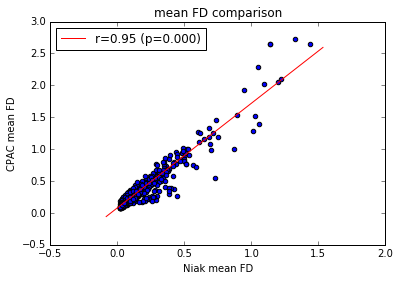

In [15]:
# And now compare the FD
x = niak_abide_test.func_mean_fd.values
Y = niak_abide_test.FD.values
mask = (np.isnan(x) | np.isnan(Y))
x = x[~mask]
Y = Y[~mask]
mval = np.max(x)
m_y = np.max(Y)

rlm_model = sm.RLM(Y, sm.add_constant(x))
rlm_results = rlm_model.fit()
plot_x = np.linspace(np.min(x)-0.1,np.max(x)+0.1,2)
plot_y = np.polyval(rlm_results.params[::-1], plot_x)
r = st.pearsonr(x, Y)

plt.scatter(x, Y)
plt.plot(plot_x, plot_y, 'r', label='r={:.2f} (p={:.3f})'.format(r[0], r[1]))
plt.legend(loc=2)
plt.xlabel('Niak mean FD')
plt.ylabel('CPAC mean FD')
plt.title('mean FD comparison')

Ok, seems like while they are not the same, they are highly correlated. So I think that's fine for now.

## QC agreement between niak and abide_preproc
Let's take a look at these values, probably need to relabel them

In [16]:
cols = ['qc_rater_1', 'qc_anat_rater_2', 'qc_func_rater_2', 'qc_anat_rater_3', 'qc_func_rater_3', 'anat', 'func']
# Remove trailing whitespace and replace empty with nan
niak_abide_test.func = niak_abide_test.func.replace({' ':np.nan}).str.strip(' ')
niak_abide_test.anat = niak_abide_test.anat.replace({' ':np.nan}).str.strip(' ')
# Replace ok, maybe and fail with [0, 0.5, 1]
for col in cols:
    niak_abide_test[col] = niak_abide_test[col].replace({'OK':1, 'Maybe':0.5,
                                                         'maybe':0.5, 'Fail':0,
                                                        'fail':0})

Get an idea of the concordance of QC ratings

In [17]:
from statsmodels.stats import inter_rater as sir

In [18]:
ratings = np.concatenate((niak_abide_test.qc_rater_1.values[..., None], niak_abide_test.qc_func_rater_3.values[..., None]),axis=1)
val_mask = np.sum(np.isnan(ratings), axis=1, dtype=bool)
table = sir.to_table(ratings[~val_mask, :])
sir.cohens_kappa(table[0])

{'alpha': 0.025,
 'alpha_ci': '  95',
 'distribution_kappa': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f04d3afe390>,
 'distribution_zero_null': <scipy.stats._distn_infrastructure.rv_frozen at 0x7f04d3b2d9b0>,
 'kappa': 0.73379157887465019,
 'kappa_low': 0.65761587600549221,
 'kappa_max': 0.75914476183896951,
 'kappa_upp': 0.80996728174380817,
 'kind': 'Simple',
 'pvalue_one_sided': 1.444206623823729e-143,
 'pvalue_two_sided': 2.888413247647458e-143,
 'std_kappa': 0.038865868694538383,
 'std_kappa0': 0.028793036140681006,
 'var_kappa': 0.0015105557493810989,
 'var_kappa0': 0.00082903893019856253,
 'weights': None,
 'z_value': 25.485036565417747}

Well, rater2 and niak have ok-ish alignment. But really there is not enough agreement between them to be happy. And since we know that the niak QC had a kappa of 0.8 I think I'll just go with that.

# Make things happen now
- merge abide_preproc and niak_qc
- get Budha's ADOS severity scores
- run propensity score matching with that

In [19]:
# Get rid of the meaningless index columns at the beginning
abide_merged = niak_abide_test.drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
# Also drop the duplicate SUB_ID column
abide_merged.drop(['X', 'subject'], axis=1, inplace=True)

In [20]:
# Now add the ADOS information
pheno_ados = pd.read_csv(path_ados)
# Ok, just checked it, this matches with the info in the abide_merged pheno
# Let's drop anything we don't need
pheno_ados = pheno_ados[['SUB_ID', 'ADOS_sb_sev', 'ADOS_sc_sev']]

In [21]:
abide_full = pd.merge(abide_merged, pheno_ados, on='SUB_ID', how='outer')

In [22]:
# Find how many subjects that pass QC have ADOS
qc_maybe = abide_full[(abide_full.anat + abide_full.func) > 1]
qc_pass = abide_full[abide_full.func == 1]
# Replace missing values
qc_maybe.replace({-9999.0:np.nan}, inplace=True)
qc_pass.replace({-9999.0:np.nan}, inplace=True)

/home/surchs/Venv/serv3/lib/python3.5/site-packages/pandas/core/generic.py:3362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  limit=limit, regex=regex)


In [23]:
# Save the stuff
qc_maybe.to_csv(qc_maybe_out, index=False)
qc_pass.to_csv(qc_pass_out, index=False)

In [28]:
abide_full[abide_full['SUB_ID']==50026].func

22    0.5
Name: func, dtype: float64

In [41]:
qc_pass[qc_pass['frames_OK']<60].shape

(47, 117)